У цьому ДЗ ми попрактикуємось моделювати часові ряди на даних з [Store Item Demand Forecasting Challenge](https://www.kaggle.com/competitions/demand-forecasting-kernels-only/overview). Ми будемо працювати лише з тренувальними даними цього змагання і задача у нас буде дещо змінена. Фокус буде на пошуці найкращої моделі, експериментах і використанні функціоналу `darts`.

Якщо якісно попрацювати в цьому завданні - це буде чудовий приклад проєкту для вашого портфоліо: "спрогнозував(-ла) поденні продажі на 1 міс для 50 товарів в 10 магазинах" звучить вражаюче! Але ми в рамках ДЗ для оптимізації часу сконцентруємось на моделюванні продажів одного товару в одному магазині.

**Задача**

Вам надано дані про продажі товарів у магазинах за 5 років. Хочемо навчитись передачати продажі в наступному місяці поденно кожного з 50 товарів у кожному з 10 магазинів. Відповідно будемо проводити експерименти, аби знайти найкращу модель для цього.

На відміну від змагання, ми будемо використовувати метрику МАРЕ (Mean Absolute Percentage Error) замість SMAPE (Symmetric Mean Absolute Percentage Error). Проте, ви також можете розрахувати SMAPE і подати свої результати через late submission на Kaggle.

1. Завантажуємо дані в Pandas.

  1. Завантажте дані з файлу `train.csv.zip` за допомогою бібліотеки Pandas.
  2. Перетворіть колонку `date` на формат `datetime`.
  3. Встановіть колонку `date` як індекс для датафрейму.
  4. Виведіть перші 10 рядків отриманого датафрейму та інформацію про датафрейм.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_predict

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
df = pd.read_csv("/content/drive/MyDrive/ML_Course/Data/time_series/train.csv")

In [4]:
df['date'] = pd.to_datetime(df['date'])
df.set_index('date', inplace=True)

In [5]:
print(df.head(10))
df.info()

            store  item  sales
date                          
2013-01-01      1     1     13
2013-01-02      1     1     11
2013-01-03      1     1     14
2013-01-04      1     1     13
2013-01-05      1     1     10
2013-01-06      1     1     12
2013-01-07      1     1     10
2013-01-08      1     1      9
2013-01-09      1     1     12
2013-01-10      1     1      9
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 913000 entries, 2013-01-01 to 2017-12-31
Data columns (total 3 columns):
 #   Column  Non-Null Count   Dtype
---  ------  --------------   -----
 0   store   913000 non-null  int64
 1   item    913000 non-null  int64
 2   sales   913000 non-null  int64
dtypes: int64(3)
memory usage: 27.9 MB


  2. Давайте трошки зрозуміємо дані. У нас 10 магазинів і 50 айтемів в кожному. Хочемо зрозуміти, чи відрізняється динаміка по кожному айтему в магазинах. Як би ви це візуалізували? Побудуйте 3 графіка, які вам допоможуть. Можна використати будь-який інструмент: matplotlib, seaborn, plotly.

  Напишіть висновок з побудованих вами візуалізацій.
  
    **Підказка**: я б спробувала вивести середнє значення і довірчий інтервал (який включає весь діапазон значень з різних магазинів) для динаміки кожного айтема, або принаймні для декількох айтемів, аби зрозуміти тенденцію.



<Figure size 1500x600 with 0 Axes>

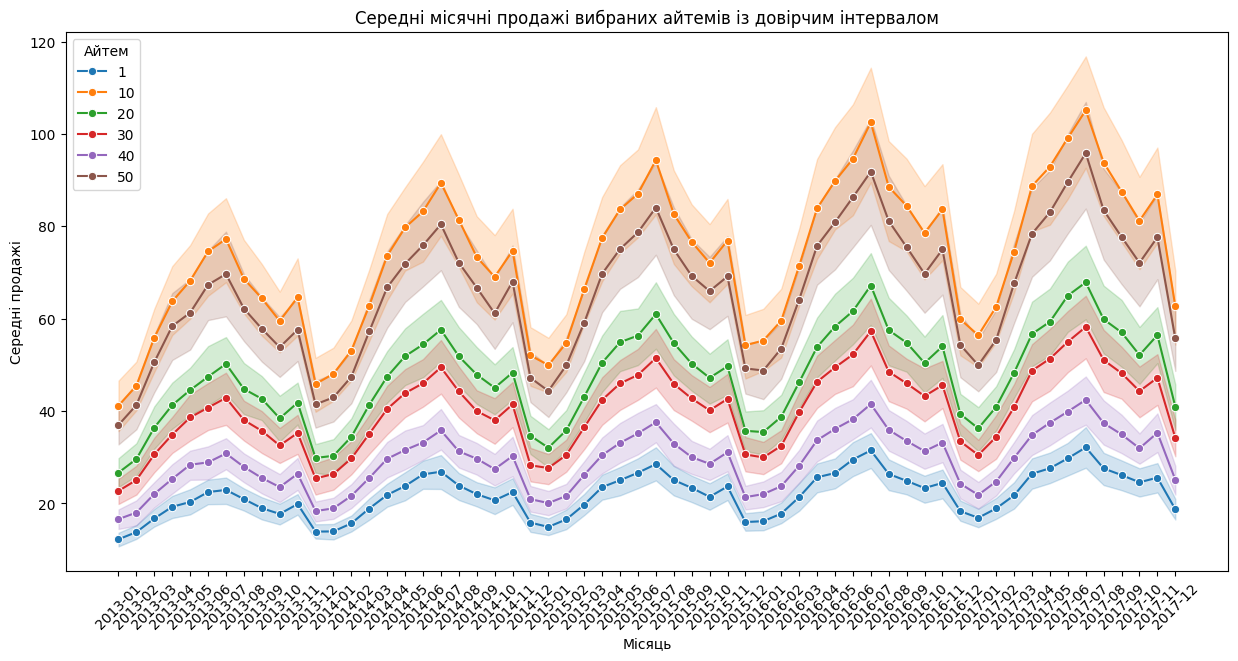

In [6]:
df["month"] = df.index.to_period("M").astype(str)

monthly_sales = df.groupby(["month", "store", "item"])["sales"].mean().reset_index()


plt.figure(figsize=(15, 6))
sample_items = [1, 10, 20, 30, 40, 50]
sample_df = monthly_sales[monthly_sales["item"].isin(sample_items)]

custom_palette = ["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd", "#8c564b"]
plt.figure(figsize=(15, 7))

sns.lineplot(data=sample_df, x="month", y="sales", hue="item", errorbar=('ci', 95), marker="o", palette=custom_palette)

plt.title("Середні місячні продажі вибраних айтемів із довірчим інтервалом")
plt.xlabel("Місяць")
plt.ylabel("Середні продажі")
plt.xticks(rotation=45)
plt.legend(title="Айтем")
plt.show();

Для побудови графіку я обрала 6 різних товарів, які мають не послідовні значення id, щоб уникнути вибору товарів, що відносяться до однієї категорії.  
Відповідно до візуалізації можна сказати, що товари в цілому мають однаковий патерн кількості продажів в часі: зростання і спадання відбуваються в однакові проміжки часу для всіх товарів.  
Товари 1 та 40 мають найбільш постійний розмір довірчого інтервалу на протязі всього часу, що може свідчити про те, що в різних магазинах продажі мають приблизно однакові значення.  
По всім іншим товарам спостерігаємо зміну значень довірчого інтервалу в різні відтинки часу, що свідчить про наявну різницю в кількості продажів одного і того ж товару в різних магазинах.  

3. **Для початку проаналізуємо лише один ряд, а далі зможемо зациклити тренування моделей.**
  
  Виберіть підмножину даних, що відповідає продажам товару з `item == 1` у магазині з `store == 1`.

  Зробіть декомпозицію цього рядку за адитивною моделлю на тренд, сезонність і залишки з бібліотекою `statsmodels`.

  Зробіть висновки з отриманих візуалізацій. Чи щось би могло вам допомогти ліпше зрозуміти ці візуалізації? (з точки зору обробки даних)

In [7]:
df_item_1 = df[(df['item'] == 1) & (df['store'] == 1)]

In [8]:
df_item_1.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1826 entries, 2013-01-01 to 2017-12-31
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   store   1826 non-null   int64 
 1   item    1826 non-null   int64 
 2   sales   1826 non-null   int64 
 3   month   1826 non-null   object
dtypes: int64(3), object(1)
memory usage: 71.3+ KB


In [9]:
result = adfuller(df_item_1['sales'])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -3.157671
p-value: 0.022569
Critical Values:
	1%: -3.434
	5%: -2.863
	10%: -2.568


In [10]:
# decomposition_plot_multi = seasonal_decompose(df_item_1['sales'],
#                                               model='additive',
#                                               two_sided=False,
#                                               extrapolate_trend='freq'
#                                              )
# decomposition_plot_multi.plot()
# fig.set_size_inches(15, 10)
# plt.show();

Оскільки графіки доволі маленькі за розміром, я прийняла рішення візуалізувати їх трохи інакше, щоб можна було краще аналізувати результати

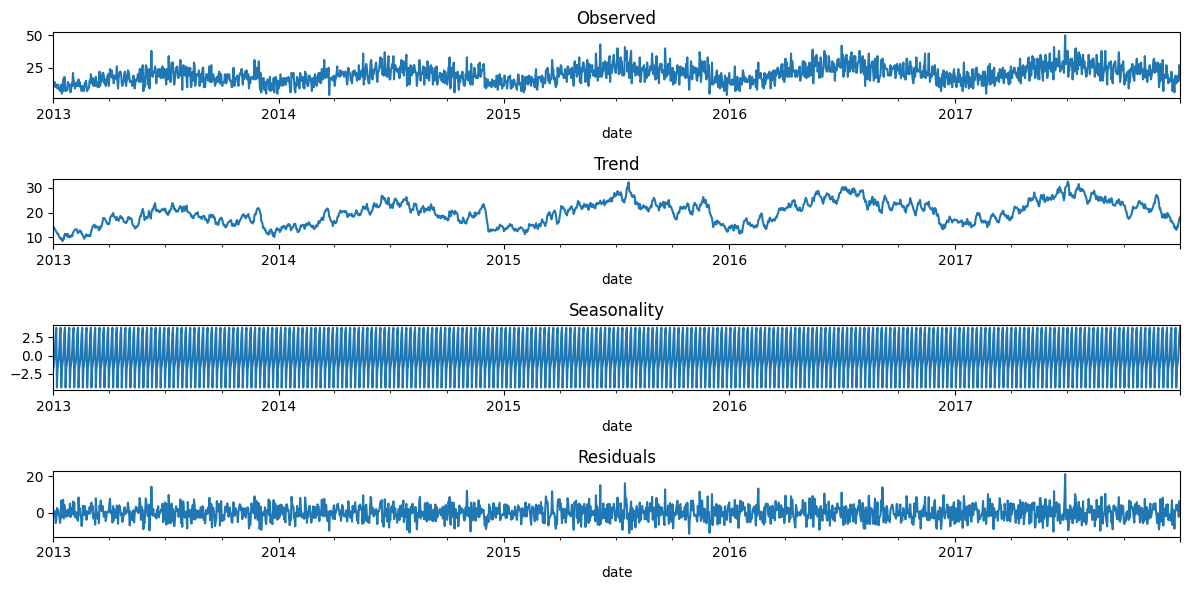

In [11]:
decomposition_plot_multi = seasonal_decompose(
    df_item_1['sales'],
    model='additive',
    two_sided=False,
    extrapolate_trend='freq'
)

fig, axes = plt.subplots(4, 1, figsize=(12, 6))

decomposition_plot_multi.observed.plot(ax=axes[0], title="Observed")
decomposition_plot_multi.trend.plot(ax=axes[1], title="Trend")
decomposition_plot_multi.seasonal.plot(ax=axes[2], title="Seasonality")
decomposition_plot_multi.resid.plot(ax=axes[3], title="Residuals")

plt.tight_layout()
plt.show();

Після декомпозиції часового ряду можемо сказати, що тренд є хвилеобразний і має деяку сезонність - зростання на початку року і спадання на прикінці.  
Загальний тренд - зростаючий, з невеликими змінами. Скоріше прагне до стабільного.  
Сезонність яскраво виражена, з постійною амплітудою. Щільність результатів вказує скоріше на щотижневу сезонність, ніж на щомісячну. Проте це потребує додаткової перевірки.  
Резідули не мають виражених патернів. У більшості випадків розташовані навколо 0.

Для спрощення інтерпретації можемо загрегувати дані помісячно і ще раз подивитись на результати декомпозиції.

In [12]:
df_item_1_month = df_item_1.asfreq('ME')

In [13]:
# decomposition_plot_multi = seasonal_decompose(df_item_1_month['sales'],
#                                               model='additive',
#                                               two_sided=False,
#                                               extrapolate_trend='freq'
#                                               )
# plt.figure(figsize=(15, 5))
# decomposition_plot_multi.plot()
# plt.show();

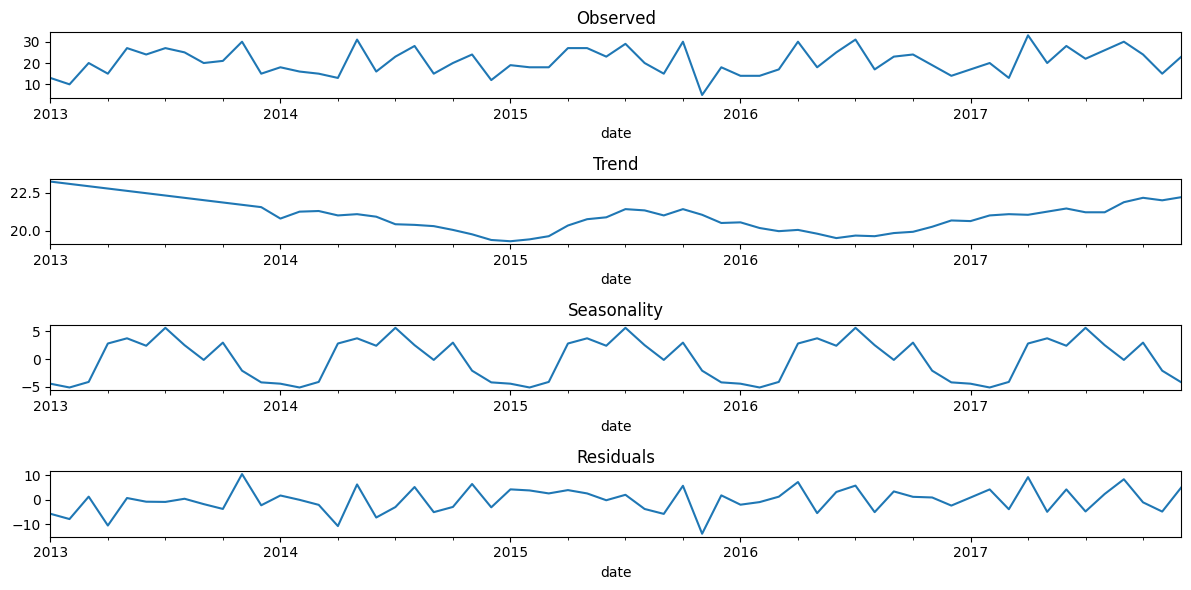

In [14]:
decomposition_plot_multi = seasonal_decompose(
    df_item_1_month['sales'],
    model='additive',
    two_sided=False,
    extrapolate_trend='freq'
)

fig, axes = plt.subplots(4, 1, figsize=(12, 6))

decomposition_plot_multi.observed.plot(ax=axes[0], title="Observed")
decomposition_plot_multi.trend.plot(ax=axes[1], title="Trend")
decomposition_plot_multi.seasonal.plot(ax=axes[2], title="Seasonality")
decomposition_plot_multi.resid.plot(ax=axes[3], title="Residuals")

plt.tight_layout()
plt.show();

Тренд так само демонструє загальне слабке зростання, з максимальною просадкою на прикінці 2014 року.  
В агрегованому варіанті можемо бачити можливу наявність річної та квартальної сезонності.  
Резидули так само не демонструють патернів.

4. Зі створеної підможени даних в попередньому пункті створіть обʼєкт класу `TimeSeries` в `darts` лише для колонки `sales`.

In [15]:
!pip install darts --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.7/55.7 kB 3.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 169.6/169.6 kB 12.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 972.2/972.2 kB 44.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 60.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 819.3/819.3 kB 43.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 354.4/354.4 kB 24.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.0/44.0 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.7/101.7 kB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 57.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 46.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 33.1 MB/s eta 0:00:00

In [16]:
from darts import TimeSeries
from darts.utils.statistics import plot_pacf, check_seasonality

In [17]:
series = TimeSeries.from_dataframe(df_item_1, value_cols='sales')

In [18]:
series

<TimeSeries (DataArray) (date: 1826, component: 1, sample: 1)> Size: 15kB
array([[[13.]],

       [[11.]],

       [[14.]],

       ...,

       [[15.]],

       [[27.]],

       [[23.]]])
Coordinates:
  * date       (date) datetime64[ns] 15kB 2013-01-01 2013-01-02 ... 2017-12-31
  * component  (component) object 8B 'sales'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None

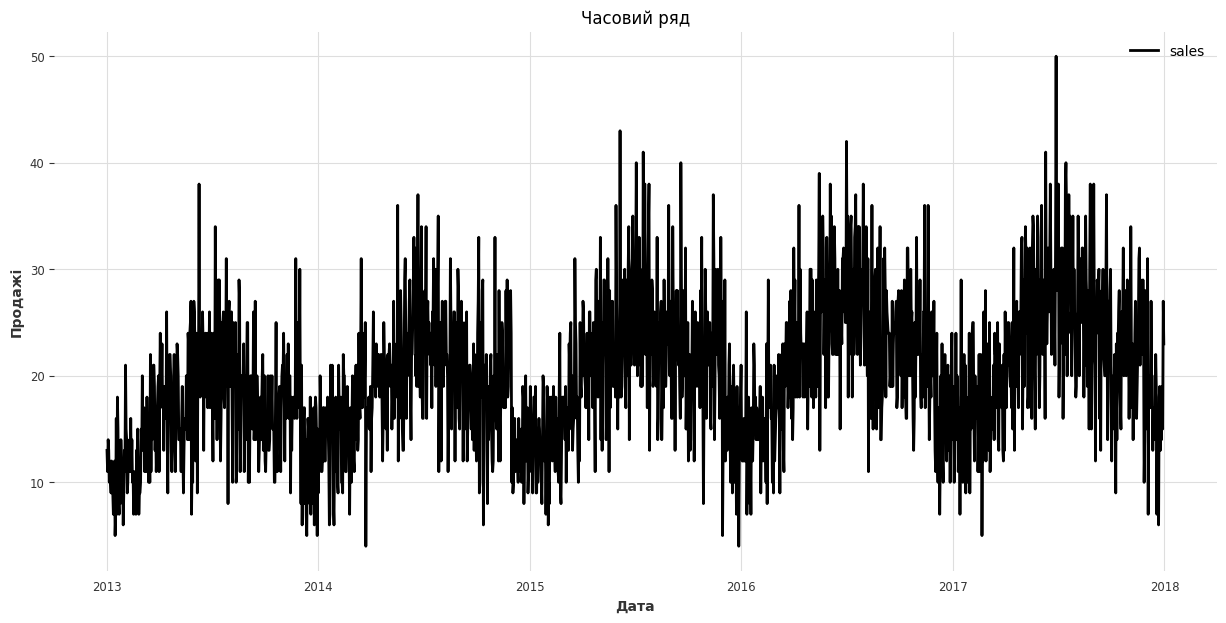

In [19]:
plt.figure(figsize=(15, 7))
series.plot()
plt.title("Часовий ряд")
plt.xlabel("Дата")
plt.ylabel("Продажі")
plt.show();

5. Використовуючи метод `series.split_before` розбийте дані на тренування і валідацію так, аби валідація починалась з `2017-10-01` включно.

  Візуалізуйте на одному графіку тренувальну і валідаційну частину як було показано в лекції.

In [20]:
split_date = pd.Timestamp("2017-10-01")
train, test = series.split_before(split_date)

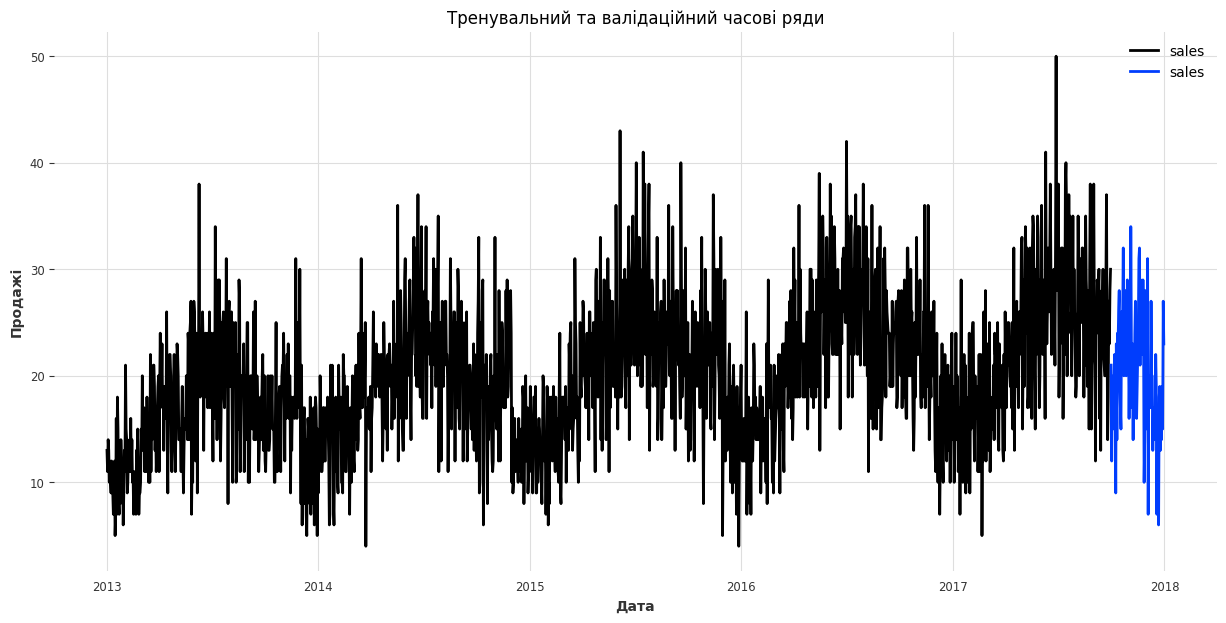

In [21]:
plt.figure(figsize=(15, 7))
train.plot()
test.plot()
plt.title("Тренувальний та валідаційний часові ряди")
plt.xlabel("Дата")
plt.ylabel("Продажі")
plt.show();

6. Побудуйте часткову автокореляційну фукнцію для цього нашого ряду в `series`. Напишіть висновки - які лаги є важливими для прогнозування?

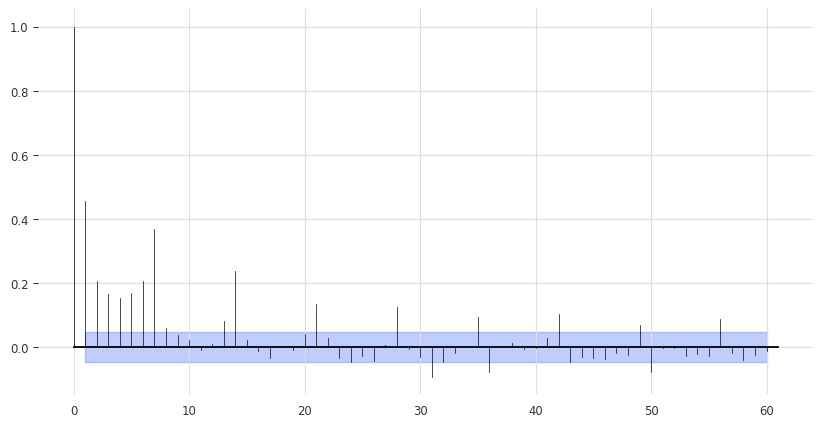

In [22]:
plot_pacf(train, max_lag=60, alpha=0.05)
plt.show();

Відповідно до отриманого результату, найважливішими лагами є 2, 7, 14, а також кожний попередній кратний 7 лаг. Що підтверджує нашу гіпотезу про щотижневу сезонність. Лаги з 3 по 6 також мають вплив на прогнозування.  
Для перевірки квартальної та річної сезонності розрахуємо також часткову автокореляцію з max_lag = 400

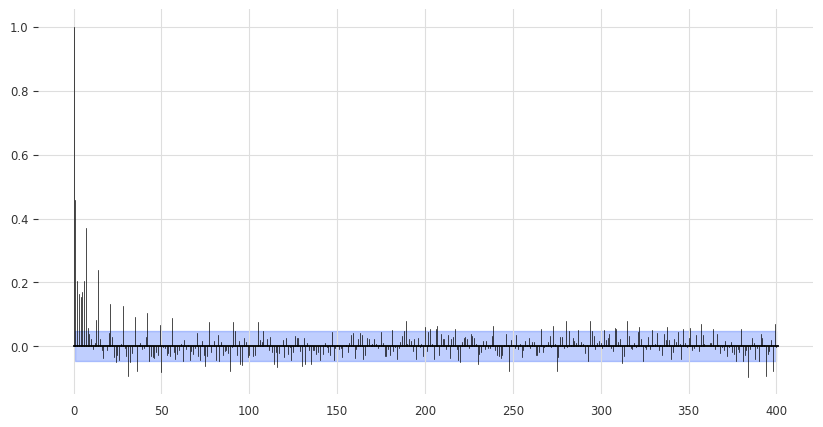

In [23]:
plot_pacf(train, max_lag=400, alpha=0.05)
plt.show();

Відповідно до отриманого результату я не бачу впливу квартальних або річного лагів на передбачення.

7. Виявіть сезональність тренувального ряду використовуючи фукнкцію `check_seasonality` з `darts`.

In [24]:
for m in range(2, 31):
    is_seasonal, period = check_seasonality(train, max_lag=90, m=m, alpha=0.05)
    if is_seasonal:
        print("There is seasonality of order {}.".format(period))

There is seasonality of order 7.
There is seasonality of order 14.
There is seasonality of order 21.
There is seasonality of order 28.


In [25]:
days = [7, 14, 21, 28, 90, 180, 365]

for m in days:
    is_seasonal, period = check_seasonality(train, max_lag=400, m=m, alpha=0.05)
    if is_seasonal:
        print("There is seasonality of order {}.".format(period))

There is seasonality of order 7.
There is seasonality of order 14.
There is seasonality of order 21.
There is seasonality of order 28.


Дана перевірка підтверджує наші попередні висновки. Сезонність часового ряду є щотижневою (всі лаги, кратні 7)

8. Побудуйте наївну модель NaiveSeasonal + NaieDrift для прогнозування даних. Кількість кроків для прогнозування визначіть зі свого аналізу в попередніх пунктах. Візуалізайте передбачення проти справжніх даних так, аби було видно якість передбачень. Зробіть висновок про модель. Вона точна?

  Якщо у вас є ідеї, як поліпшити якість передбачення саме наївними моделями - реалізуйте їх в цьому пункті :)

In [26]:
from darts.models import NaiveSeasonal

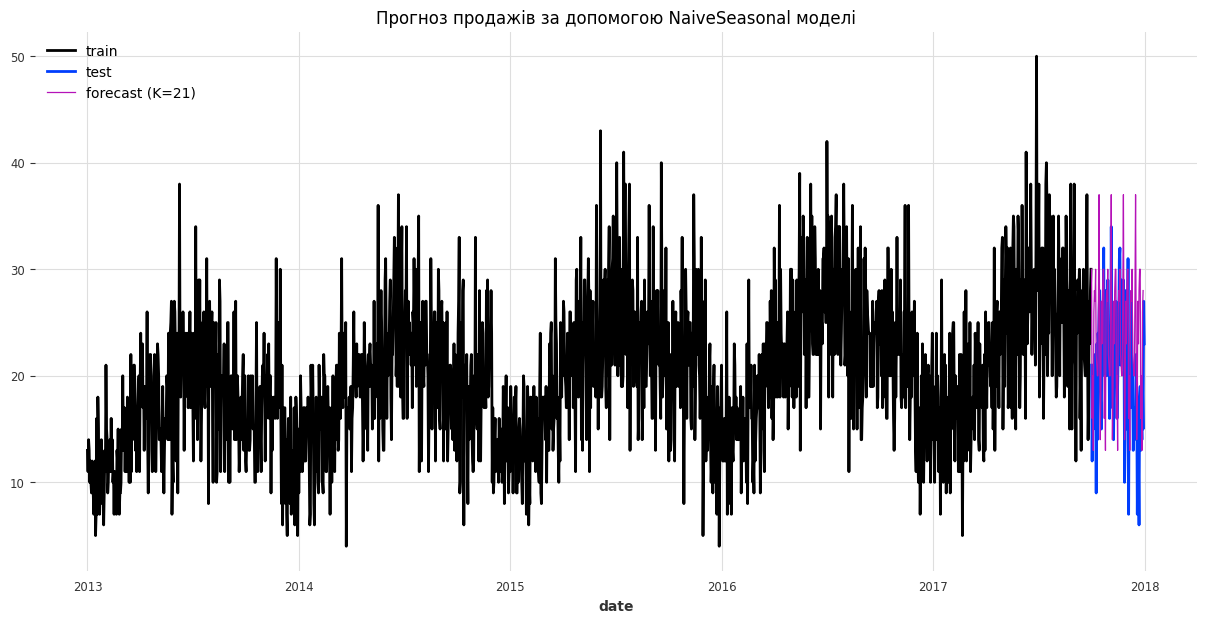

In [27]:
naive_model = NaiveSeasonal(K=21)
naive_model.fit(train)
seasonal_forecast = naive_model.predict(90)
model_name = type(naive_model).__name__

plt.figure(figsize=(15, 7))
train.plot(label="train")
test.plot(label="test")
seasonal_forecast.plot(label="forecast (K=21)", lw=0.9)
plt.title(f'Прогноз продажів за допомогою {model_name} моделі');

Візуально виглядає так, що модель передбачає правильно приблизно 50% даних. Проте вона не враховує тренд, а також не враховує щорічний спад в районі 8-9 місяця, оскільки її прогноз базується на попередніх 21 днях.

In [28]:
from darts.models import NaiveDrift

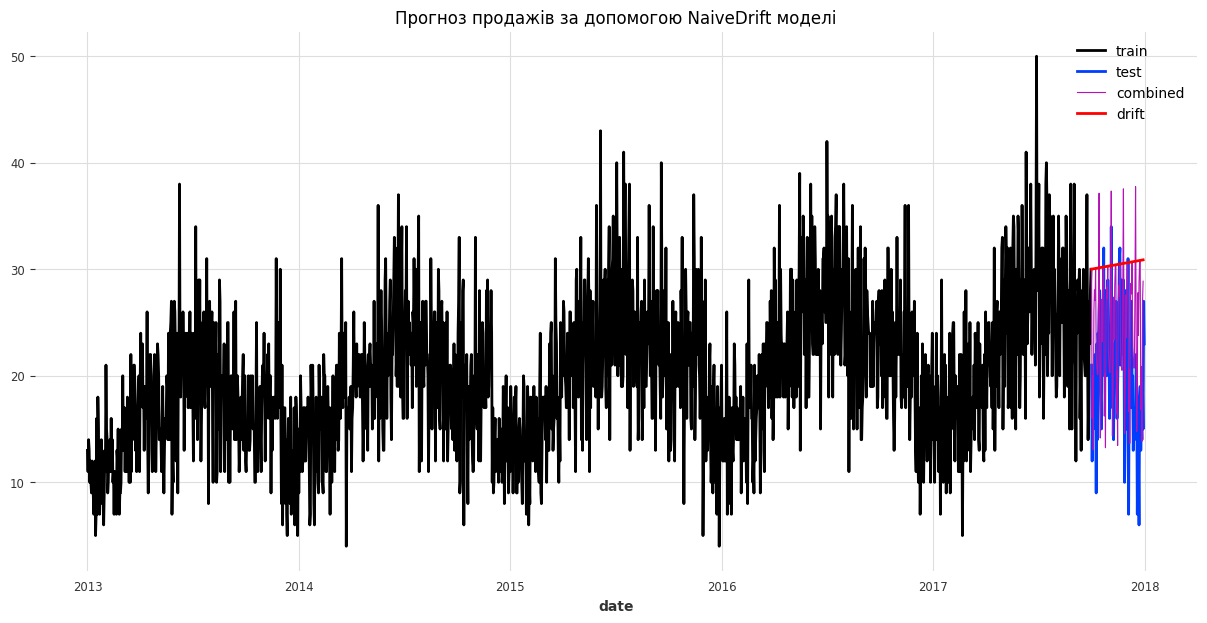

In [29]:
drift_model = NaiveDrift()
drift_model.fit(train)
drift_forecast = drift_model.predict(90)

combined_forecast = drift_forecast + seasonal_forecast - train.last_value()

model_name = type(drift_model).__name__

plt.figure(figsize=(15, 7))
train.plot(label="train")
test.plot(label="test")
combined_forecast.plot(label="combined", lw=0.8)
drift_forecast.plot(label="drift", color="red")
plt.title(f'Прогноз продажів за допомогою {model_name} моделі');

Drift модель враховує тренд, проте так само прогнозує не надто якісно.

9. Обчисліть помилку прогнозу на валідації наївною моделлю з mape. Далі для всіх моделей необхідно обчислювати помилку прогнозу на валідації.

In [30]:
from darts.metrics import mape

print(
    f"Mean absolute percentage error for the combined naive drift + seasonal: {mape(test, combined_forecast[:len(test)]):.2f}%."
    )

Mean absolute percentage error for the combined naive drift + seasonal: 39.66%.


Як бачимо, за результами обчислення mape для drift моделі, модель помиляється майже в 40% випадках. Що не є дуже гарним результатом.

10. Натренуйте XBGModel з `darts` для передбачення наших даних. Можна додавати всі додаткові ознаки, які вважаєте за потрібне, наприклад, ознаки з дати. Зробіть висновок про якість моделі.

In [31]:
from darts.models import XGBModel
from darts.dataprocessing.transformers import Scaler
from darts.utils.timeseries_generation import datetime_attribute_timeseries

Для зручності в подальшій роботі визначимо функцію, що буде візуалізувати тренувальний та тестовий часові ряди, передбачення, зроблене моделлю, а також розраховувати та виводити значення mape.

In [32]:
def forecast_plot_mape(model, train, test, forecast):
  model_name = type(model).__name__
  plt.figure(figsize=(15, 7))
  train.plot(label='Тренувальний набір')
  test.plot(label='Валідаційний набір')
  forecast.plot(label='Прогноз моделі')
  plt.legend()
  plt.title(f'Прогноз продажів за допомогою {model_name} моделі')
  plt.ylabel('Продажі')
  plt.xlabel('Дата')
  plt.tight_layout();


  mape_ = mape(test, forecast)
  print(f'MAPE: {mape_:.2f}%')
  return mape_

In [33]:
train.pd_dataframe()

component,sales
date,
2013-01-01,13.0
2013-01-02,11.0
2013-01-03,14.0
2013-01-04,13.0
2013-01-05,10.0
...,...
2017-09-26,18.0
2017-09-27,27.0
2017-09-28,23.0


MAPE: 25.48%


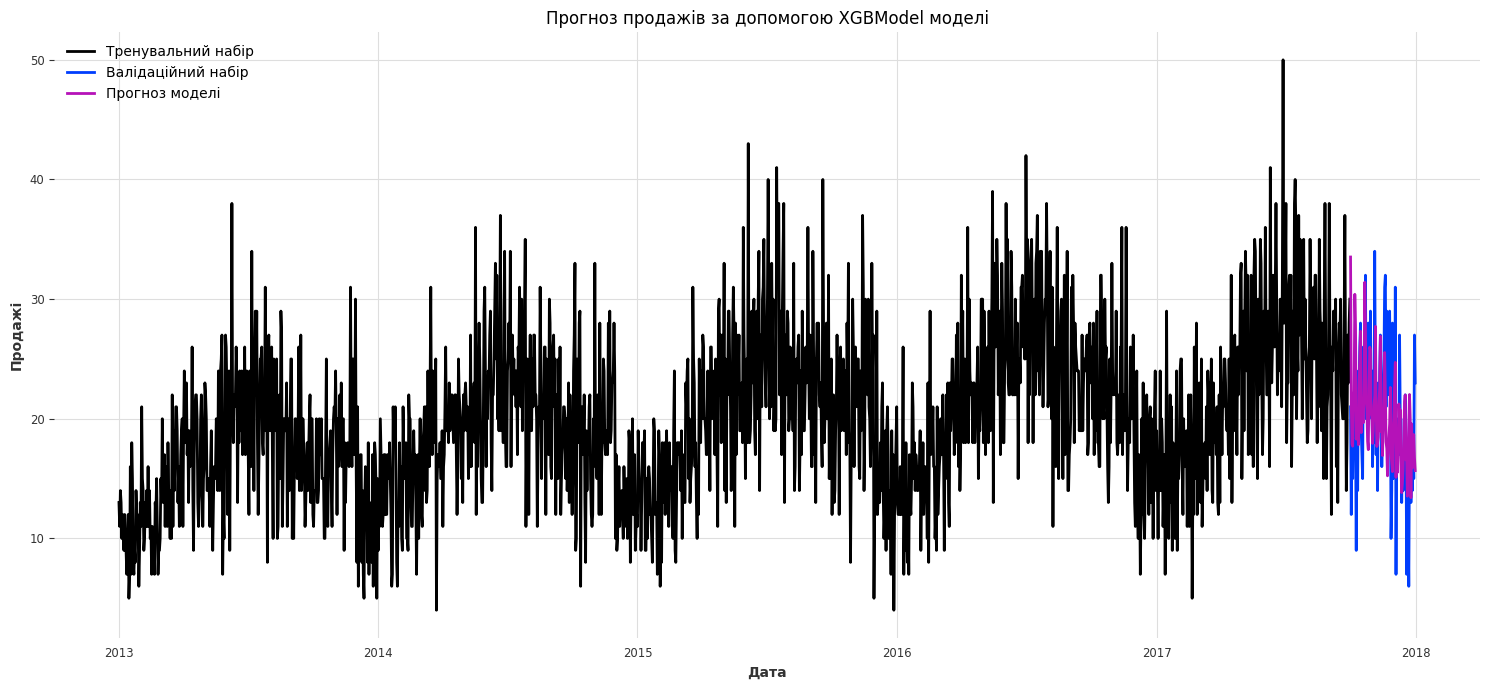

In [34]:
lags = [-i for i in range(7, 365, 7)]

model = XGBModel(
    lags=lags,
    output_chunk_length=7,
    n_estimators=300,
    max_depth=3,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state = 42

)

model.fit(train)
forecast = model.predict(len(test))
forecast_plot_mape(model, train, test, forecast);

Модель демонструє значно кращі результати, в порівнянні з наївними моделями. Нам вдалось знизити відсоток помилок до 25.48%
Спробуємо додати нові фічі

In [35]:
def enrich_with_date_features(df):
  df["dayofweek"] = df["date"].dt.dayofweek
  # df["quarter"] = df["date"].dt.quarter
  df["month"] = df["date"].dt.month
  # df["year"] = df["date"].dt.year
  # df["dayofyear"] = df["date"].dt.dayofyear
  # df["sin_day"] = np.sin(2 * np.pi * df["dayofyear"] / 365)
  # df["cos_day"] = np.cos(2 * np.pi * df["dayofyear"] / 365)
  # df["dayofmonth"] = df["date"].dt.day

  df["is_month_start"] = df["date"].dt.is_month_start.astype(int)  # Початок місяця (1 або 0)
  df["is_month_end"] = df["date"].dt.is_month_end.astype(int)  # Кінець місяця (1 або 0)

  df["sin_week"] = np.sin(2 * np.pi * df["dayofweek"] / 7)
  df["cos_week"] = np.cos(2 * np.pi * df["dayofweek"] / 7)
  return df

train_transformed = enrich_with_date_features(train.pd_dataframe().reset_index())
val_transformed = enrich_with_date_features(test.pd_dataframe().reset_index())

scaler = Scaler()
train_transformed = scaler.fit_transform(train)
val_transformed = scaler.transform(test)


lags = [-i for i in range(7, 365, 7)]

model = XGBModel(
    lags=lags,
    output_chunk_length=7,
    n_estimators=300,
    max_depth=3,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state = 42

)

model.fit(train_transformed)


XGBModel(lags=[-7, -14, -21, -28, -35, -42, -49, -56, -63, -70, -77, -84, -91, -98, -105, -112, -119, -126, -133, -140, -147, -154, -161, -168, -175, -182, -189, -196, -203, -210, -217, -224, -231, -238, -245, -252, -259, -266, -273, -280, -287, -294, -301, -308, -315, -322, -329, -336, -343, -350, -357, -364], lags_past_covariates=None, lags_future_covariates=None, output_chunk_length=7, output_chunk_shift=0, add_encoders=None, likelihood=None, quantiles=None, random_state=42, multi_models=True, use_static_covariates=True, n_estimators=300, max_depth=3, learning_rate=0.1, subsample=0.8, colsample_bytree=0.8)

MAPE: 25.48%


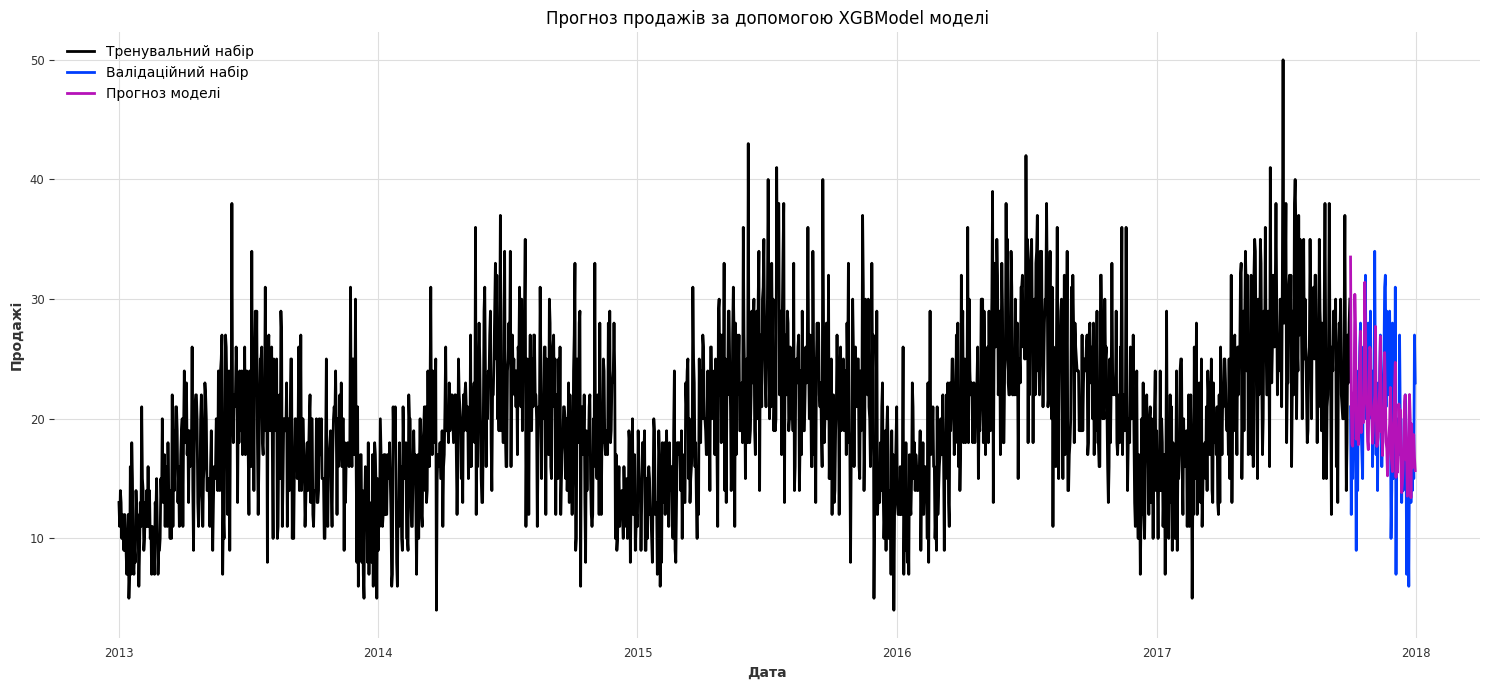

In [36]:
forecast = scaler.inverse_transform(model.predict(len(test)))
forecast_plot_mape(model, train, test, forecast);

Результати моделі не змінились   
Спробуємо змінити кількість лагів, щоб врахувати річну сезонність

In [37]:
lags = [-i for i in range(7, 800, 7)]

model = XGBModel(
    lags=lags,
    output_chunk_length=7,
    n_estimators=300,
    max_depth=3,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state = 42

)

model.fit(train_transformed)


XGBModel(lags=[-7, -14, -21, -28, -35, -42, -49, -56, -63, -70, -77, -84, -91, -98, -105, -112, -119, -126, -133, -140, -147, -154, -161, -168, -175, -182, -189, -196, -203, -210, -217, -224, -231, -238, -245, -252, -259, -266, -273, -280, -287, -294, -301, -308, -315, -322, -329, -336, -343, -350, -357, -364, -371, -378, -385, -392, -399, -406, -413, -420, -427, -434, -441, -448, -455, -462, -469, -476, -483, -490, -497, -504, -511, -518, -525, -532, -539, -546, -553, -560, -567, -574, -581, -588, -595, -602, -609, -616, -623, -630, -637, -644, -651, -658, -665, -672, -679, -686, -693, -700, -707, -714, -721, -728, -735, -742, -749, -756, -763, -770, -777, -784, -791, -798], lags_past_covariates=None, lags_future_covariates=None, output_chunk_length=7, output_chunk_shift=0, add_encoders=None, likelihood=None, quantiles=None, random_state=42, multi_models=True, use_static_covariates=True, n_estimators=300, max_depth=3, learning_rate=0.1, subsample=0.8, colsample_bytree=0.8)

MAPE: 25.64%


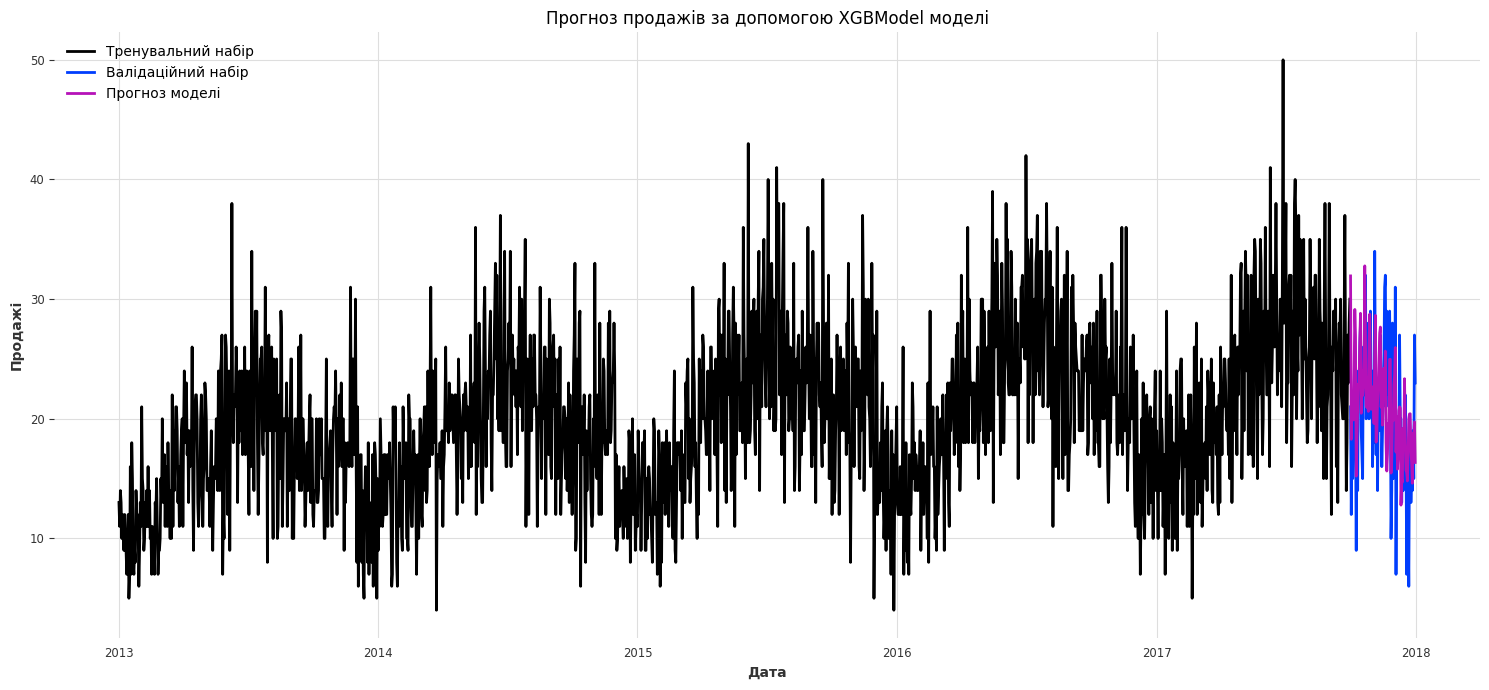

In [38]:
forecast = scaler.inverse_transform(model.predict(len(test)))
forecast_plot_mape(model, train, test, forecast);

Результат трохи погіршився.  
Спробуємо використати чистий часовий ряд без додаткових фічей (оскільки їх додавання не призвело до покращення результату) і додати минулі коваріати.
Також зменшимо кількість лагів до найвпливовіших в рамках передбачуваного періоду.

MAPE: 23.26%


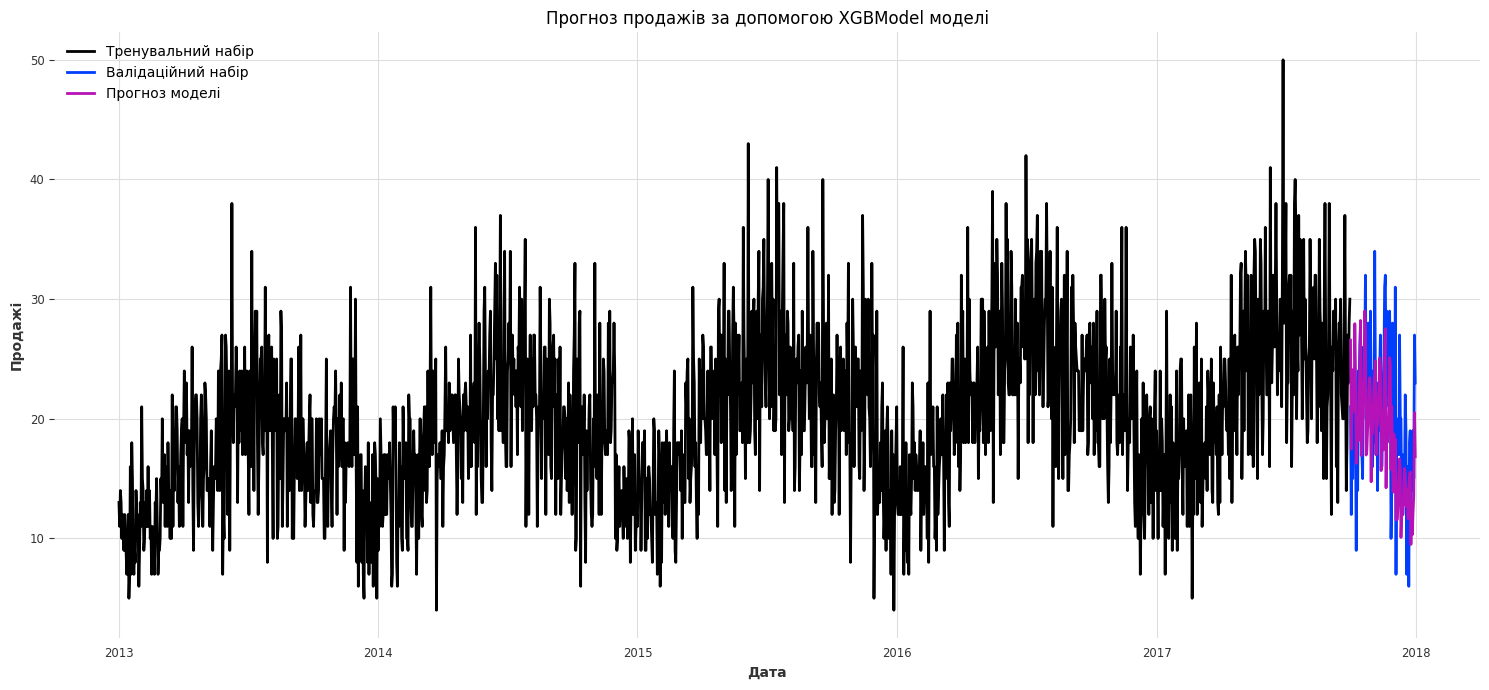

In [39]:
extended_time_index = pd.date_range(
    start=series.start_time(),
    end=series.end_time() + pd.Timedelta(days=100),
    freq=series.freq_str
)
dayofweek_extended = datetime_attribute_timeseries(
    extended_time_index,
    attribute="dayofweek",
    one_hot=True
)
month_extended = datetime_attribute_timeseries(
    extended_time_index,
    attribute="month",
    one_hot=True
)
day_extended = datetime_attribute_timeseries(
    extended_time_index,
    attribute="day",
    one_hot=True
)


temp_covariates = dayofweek_extended.concatenate(month_extended, axis=1)
all_covariates = temp_covariates.concatenate(day_extended, axis=1)


model_with_features = XGBModel(
    lags=[-1, -7, -14, -21, -28, -56, -91],
    output_chunk_length=28,
    n_estimators=300,
    max_depth=3,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state = 42,
    lags_past_covariates=[-1, -7, -14, -21, -28, -56, -91],
    verbosity=1
)

model_with_features.fit(
    train,
    past_covariates=all_covariates
)

pred_with_features = model_with_features.predict(
    n=len(test),
    past_covariates=all_covariates
)

forecast_plot_mape(model_with_features, train, test, pred_with_features);


В результаті маємо зменшення відсотку помилок ще на 2.22%  
Цього разу зміними налаштування гіперпараметрів моделі. Зменшимо глибину дерев до 2, а також період на який модель одночасно робить передбачення до 14 днів

MAPE: 21.85%


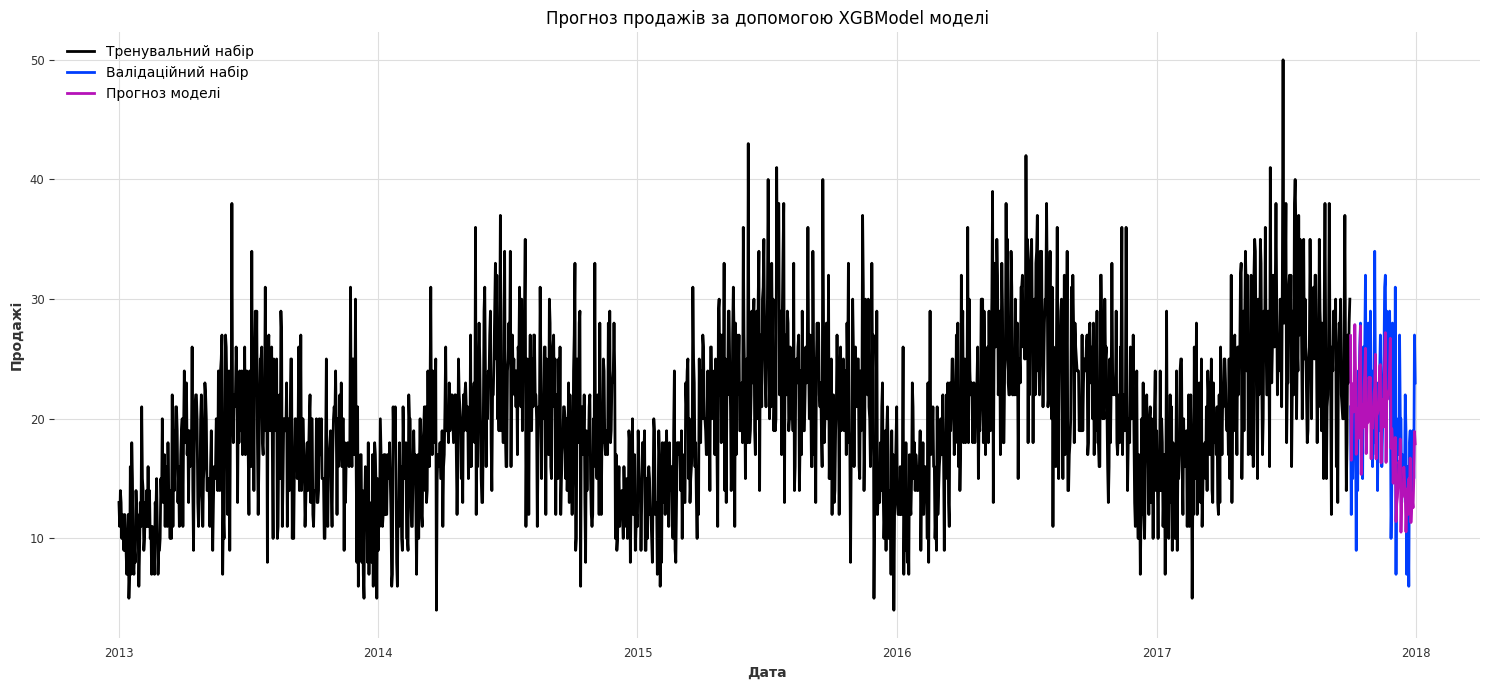

In [40]:
model_with_features_2 = XGBModel(
    lags=[-1, -7, -14, -21, -28, -56, -91],
    output_chunk_length=14,
    n_estimators=300,
    max_depth=2,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state = 42,
    lags_past_covariates=[-1, -7, -14, -21, -28, -56, -91],
    verbosity=1
)

model_with_features_2.fit(
    train,
    past_covariates=all_covariates
)

pred_with_features_2 = model_with_features_2.predict(
    n=len(test),
    past_covariates=all_covariates
)

forecast_plot_mape(model_with_features_2, train, test, pred_with_features_2);

Відсоток помилкових передбачень зменшився ще на 1.41%. На даний момент це найкраща модель з усіх попередніх.

11. Натренуйте модель ExponentialSmoothing та зробіть висновок про її якість.

MAPE: 28.44%


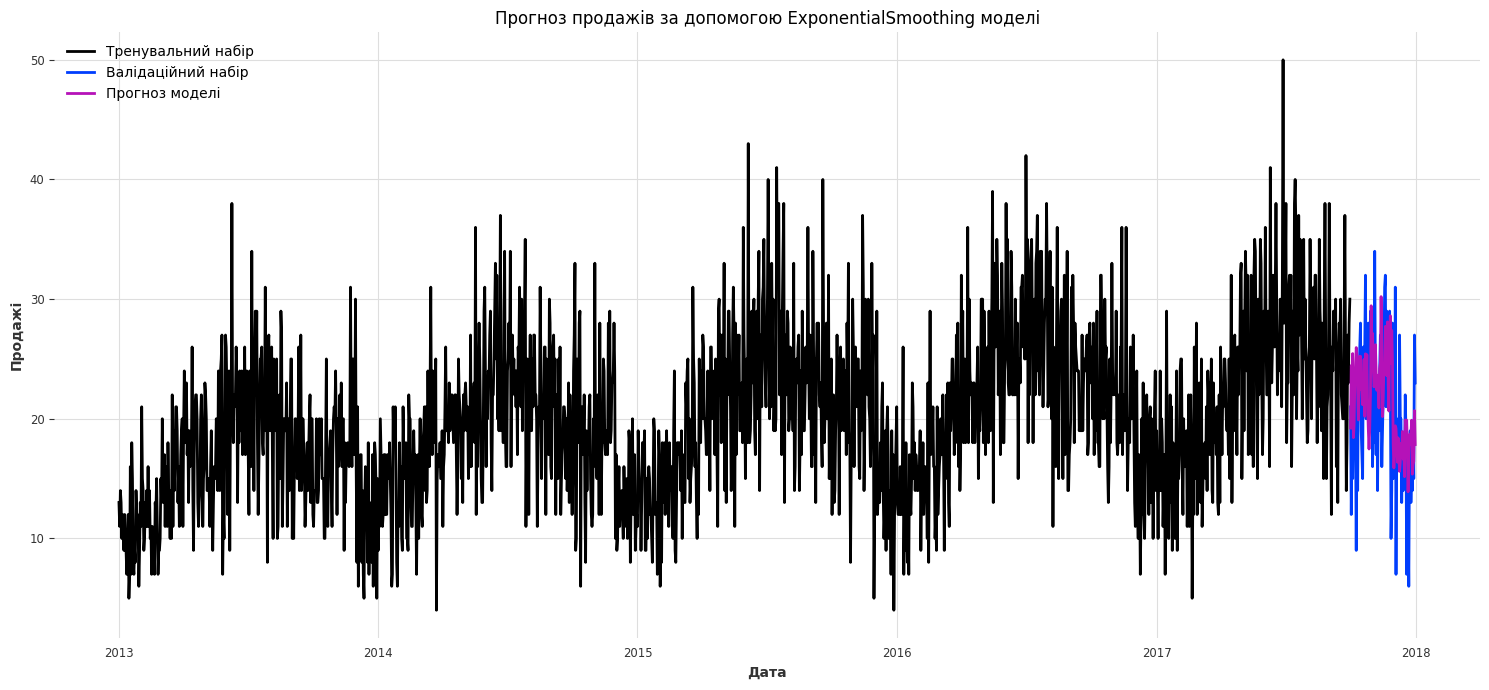

In [41]:
from darts.models import ExponentialSmoothing
from darts.utils.utils import ModelMode

es_model = ExponentialSmoothing(
    trend=ModelMode.ADDITIVE,
    seasonal=ModelMode.ADDITIVE,
    seasonal_periods=365
)
es_model.fit(train)
es_pred = es_model.predict(len(test))

forecast_plot_mape(es_model, train, test, es_pred);

Модель передбачає гірше за попередню. Найкращий результат отриманий при seasonal_periods=365. При менших значеннях результат був значно гірший.

12. Натренуйте модель ARIMA, параметри оберіть самостійно.Зробіть висновок про її якість.

/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


MAPE: 30.82%


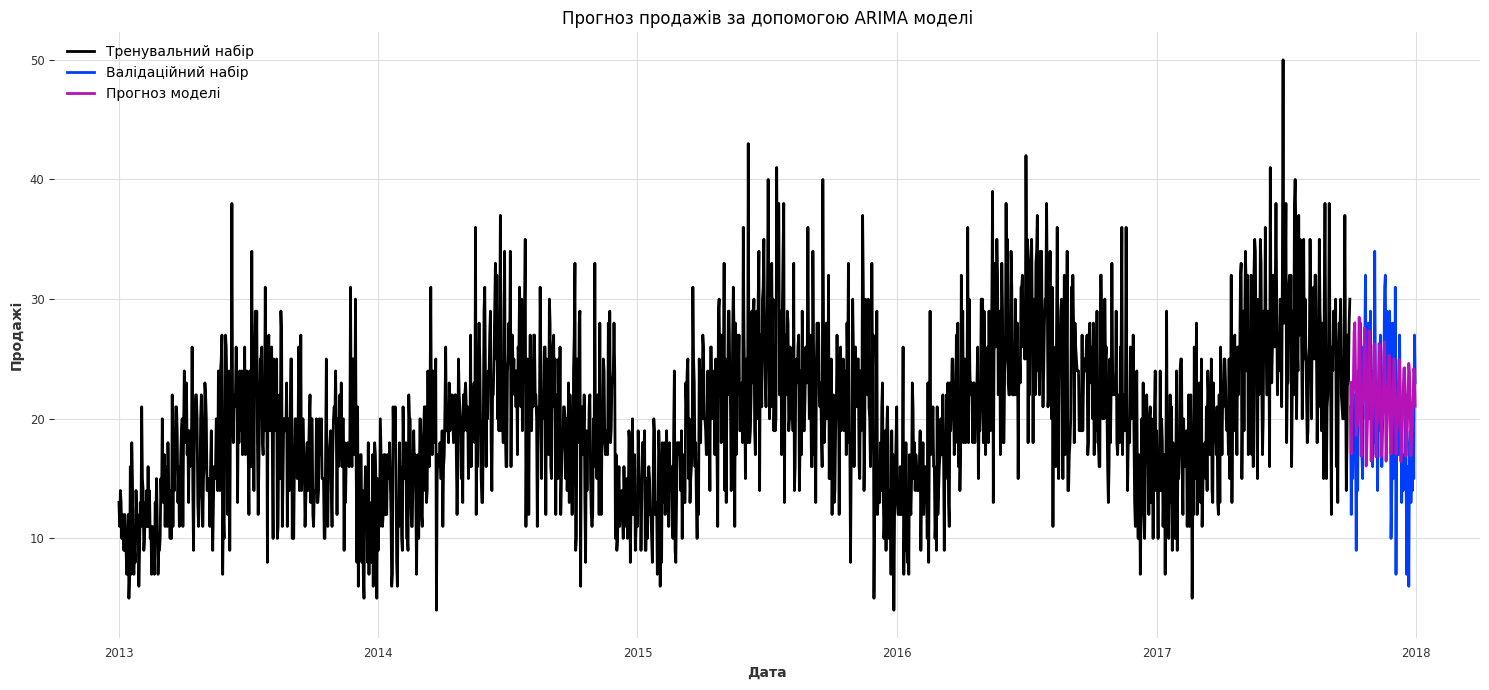

In [42]:
from darts.models import ARIMA


arima_model = ARIMA(p=56, d=0, q=7)

arima_model.fit(train)
arima_pred = arima_model.predict(len(test))

forecast_plot_mape(arima_model, train, test, arima_pred);

Якість моделі набагато гірша за попередні. Вважаю, що покращити результати можна збільшенням кількості попередніх помилок. Вважаю, що гарний результат можна було б отримати при значенні p=365, проте така модель навчалась в мене більше 4 годин.

13. Знайдіть оптимальні параметри моделі ARIMA з допомогою AutoARIMA моделі. Виконайте пошук параметрів, виведіть, які паарметри виявились оптимальними і обчисліть якість моделі. Чи поліпшилась якість порівняно з попереднім експериментом?

/usr/local/lib/python3.11/dist-packages/pmdarima/arima/_validation.py:76: UserWarning: stepwise model cannot be fit in parallel (n_jobs=1). Falling back to stepwise parameter search.
  warnings.warn('stepwise model cannot be fit in parallel (n_jobs=%i). '
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will 

MAPE: 34.60%


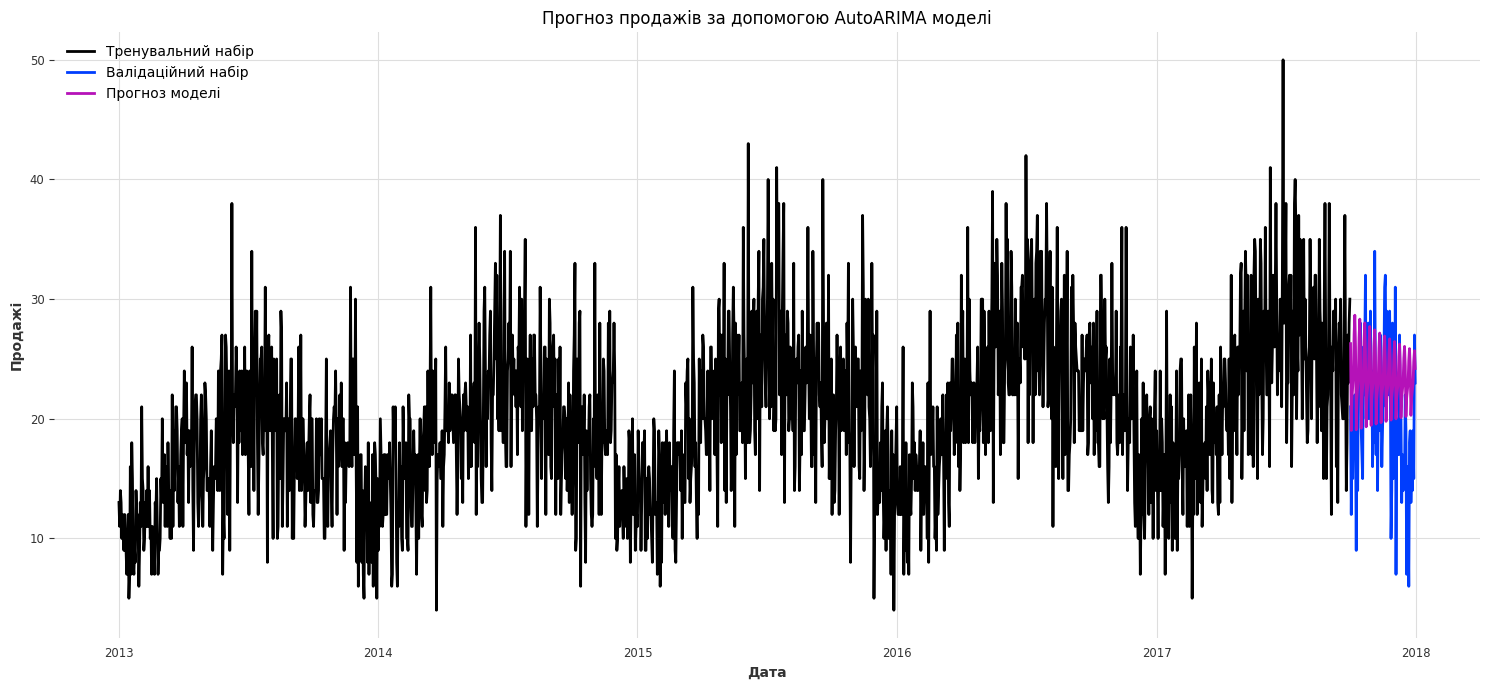

In [43]:
from darts.models import AutoARIMA

auto_arima_model = AutoARIMA(
    start_p=1, max_p=3,
    start_q=1, max_q=3,
    seasonal=True,
    m=7,
    stepwise=True,
    n_jobs=-1
)
auto_arima_model.fit(train)


auto_arima_pred = auto_arima_model.predict(len(test))

forecast_plot_mape(auto_arima_model, train, test, auto_arima_pred);

In [44]:
auto_arima_model.model.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                                       SARIMAX Results                                        
==============================================================================================
Dep. Variable:                                      y   No. Observations:                 1734
Model:             SARIMAX(3, 1, 1)x(1, 0, [1, 2], 7)   Log Likelihood               -5175.198
Date:                                Sat, 08 Mar 2025   AIC                          10368.395
Time:                                        13:27:50   BIC                          10417.514
Sample:                                             0   HQIC                         10386.562
                                               - 1734                                         
Covariance Type:                                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0003      0.001      0.302      0.763      -0.002       0.002
ar.L1          0.0858      0.027      3.180      0.001       0.033       0.139
ar.L2          0.0087      0.027      0.323      0.747      -0.044       0.062
ar.L3          0.0367      0.026      1.414      0.157      -0.014       0.088
ma.L1         -0.9563      0.009   -112.293      0.000      -0.973      -0.940
ar.S.L7        0.9521      0.014     69.751      0.000       0.925       0.979
ma.S.L7       -0.8250      0.031    -26.837      0.000      -0.885      -0.765
ma.S.L14       0.0056      0.026      0.212      0.832      -0.046       0.057
sigma2        23.8216      0.795     29.960      0.000      22.263      25.380
===================================================================================
Ljung-Box (L1) (Q):                   0.18   Jarque-Bera (JB):                13.04
Prob(Q):                              0.67   Prob(JB):                         0.00
Heteroskedasticity (H):               1.32   Skew:                             0.13
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.33
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Модель з автоматично підібраними гіперпараметрами показала гірший результат

14. Натренуйте модель Prophet та зробіть висновок про її якість.

In [45]:
from darts.models import Prophet

DEBUG:cmdstanpy:input tempfile: /tmp/tmphfpaorzv/60psynpq.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmphfpaorzv/i2agjqmg.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=80477', 'data', 'file=/tmp/tmphfpaorzv/60psynpq.json', 'init=/tmp/tmphfpaorzv/i2agjqmg.json', 'output', 'file=/tmp/tmphfpaorzv/prophet_modelsdxdqwei/prophet_model-20250308132750.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:27:50 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:27:50 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


MAPE: 22.94%


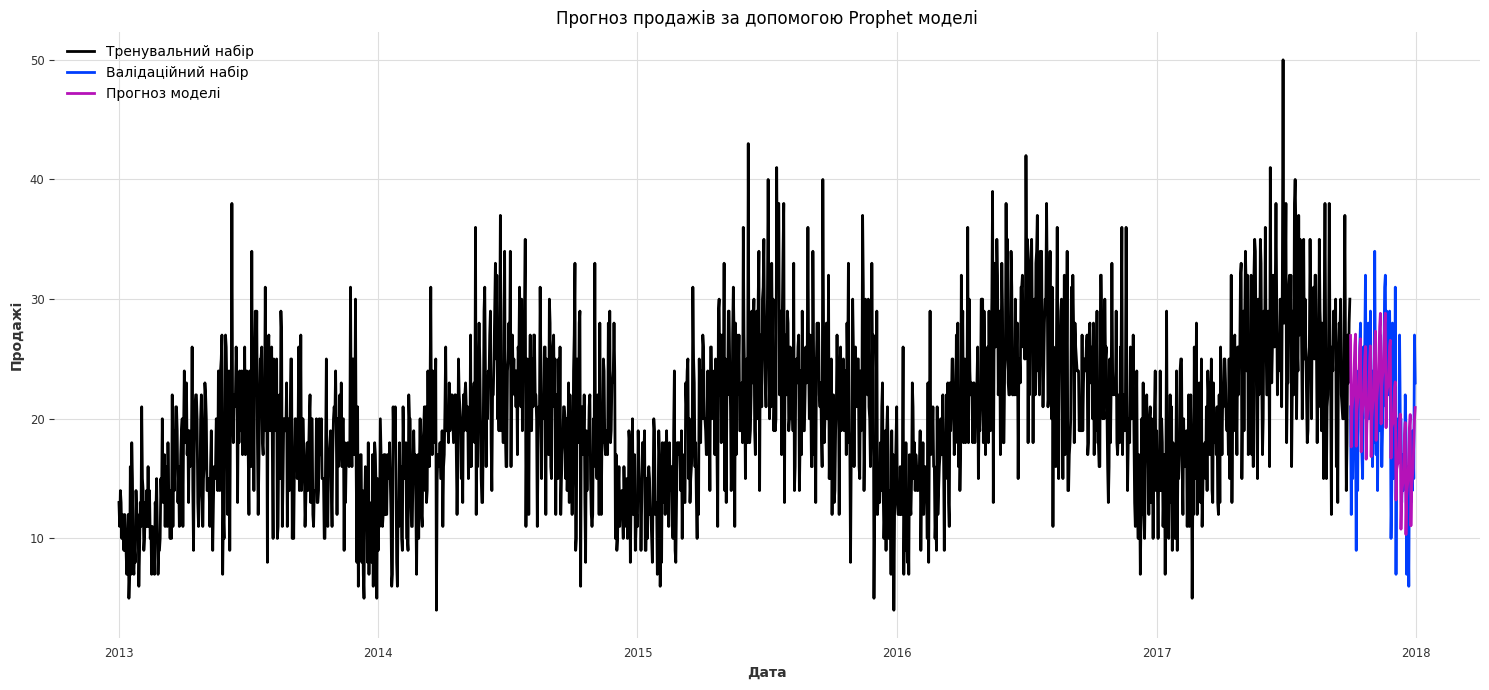

In [46]:
model_prophet = Prophet(
    growth="linear",
    changepoint_prior_scale=0.1,
    seasonality_mode="multiplicative",
    yearly_seasonality=True,
    weekly_seasonality=True,
    daily_seasonality=False,
    seasonality_prior_scale=20,
    holidays_prior_scale=5,
    interval_width=0.95
)
model_prophet.fit(train)

prophet_pred = model_prophet.predict(len(test))

forecast_plot_mape(model_prophet, train, test, prophet_pred);

Модель демонструє непогані результати, проте не найкращі.

15. Натренуйте модель `RNNModel` та зробіть висновок про її якість.

In [47]:
from darts.models import RNNModel

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 199 K  | train
6 | V               | Linear           | 129    | train
-------------------------------------------------------------
199 K     Trainable params
0         Non-trainable params
199 K     Total params
0.797     Total estimated model params size (MB)
7         

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=100` reached.


MAPE: 25.64%


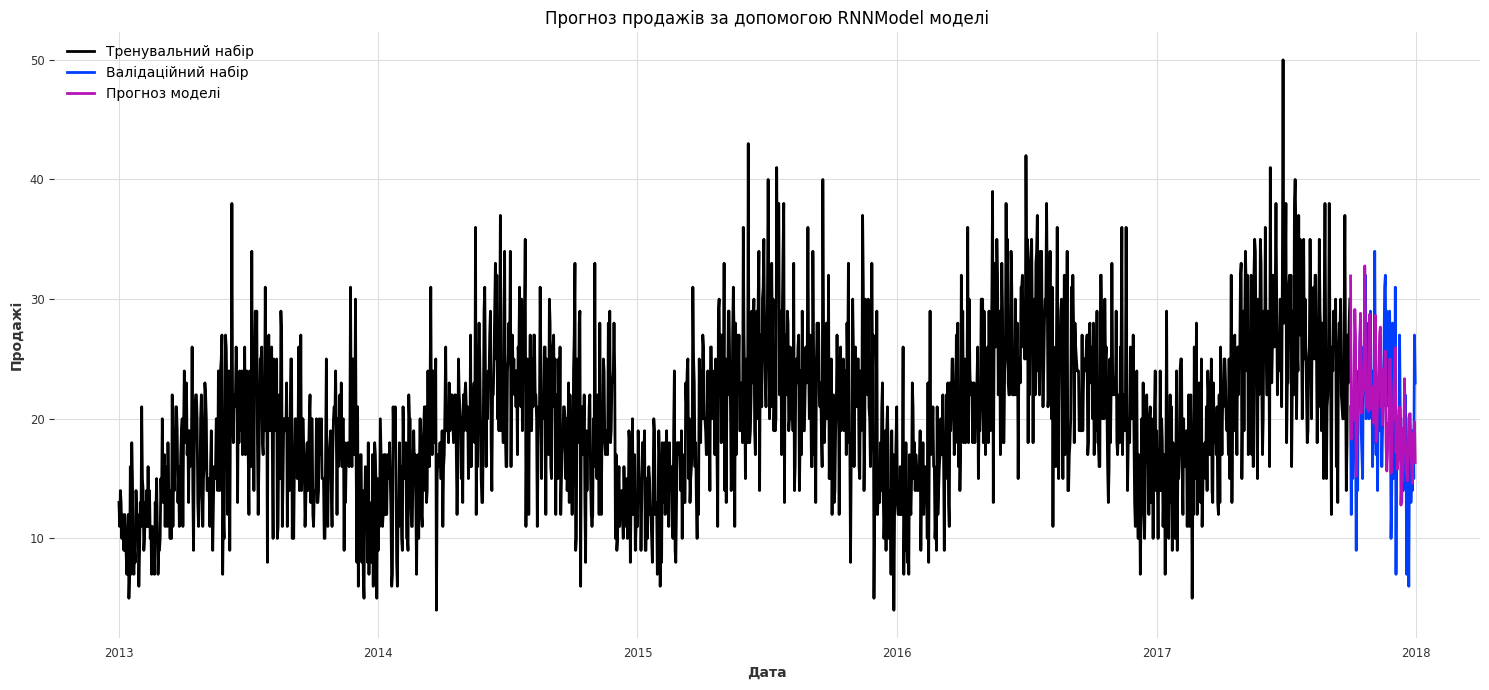

In [48]:
model_lstm = RNNModel(
    model='LSTM',
    input_chunk_length=58,
    output_chunk_length=7,
    hidden_dim=128,
    n_rnn_layers=2,
    dropout=0.1,
    batch_size=64,
    optimizer_kwargs={"lr": 0.001},
    n_epochs=100,
    random_state=42,
    training_length=91
)

model_lstm.fit(train)

pred_lstm = scaler.inverse_transform(model.predict(len(test)))

forecast_plot_mape(model_lstm, train, test, pred_lstm);

Попередня модель показала кращій результат

16. Виконайте бектест для тої моделі, яка виявилась найкращою у вашому дослідженні на періоді 1 рік з передбаченнями на 1 місяць щоразу. Візуалізуйте як поводилась модель протягом бектесту, яка була точність?

historical forecasts: 100%|██████████| 363/363 [21:50<00:00,  3.61s/it]


MAPE: 20.84%


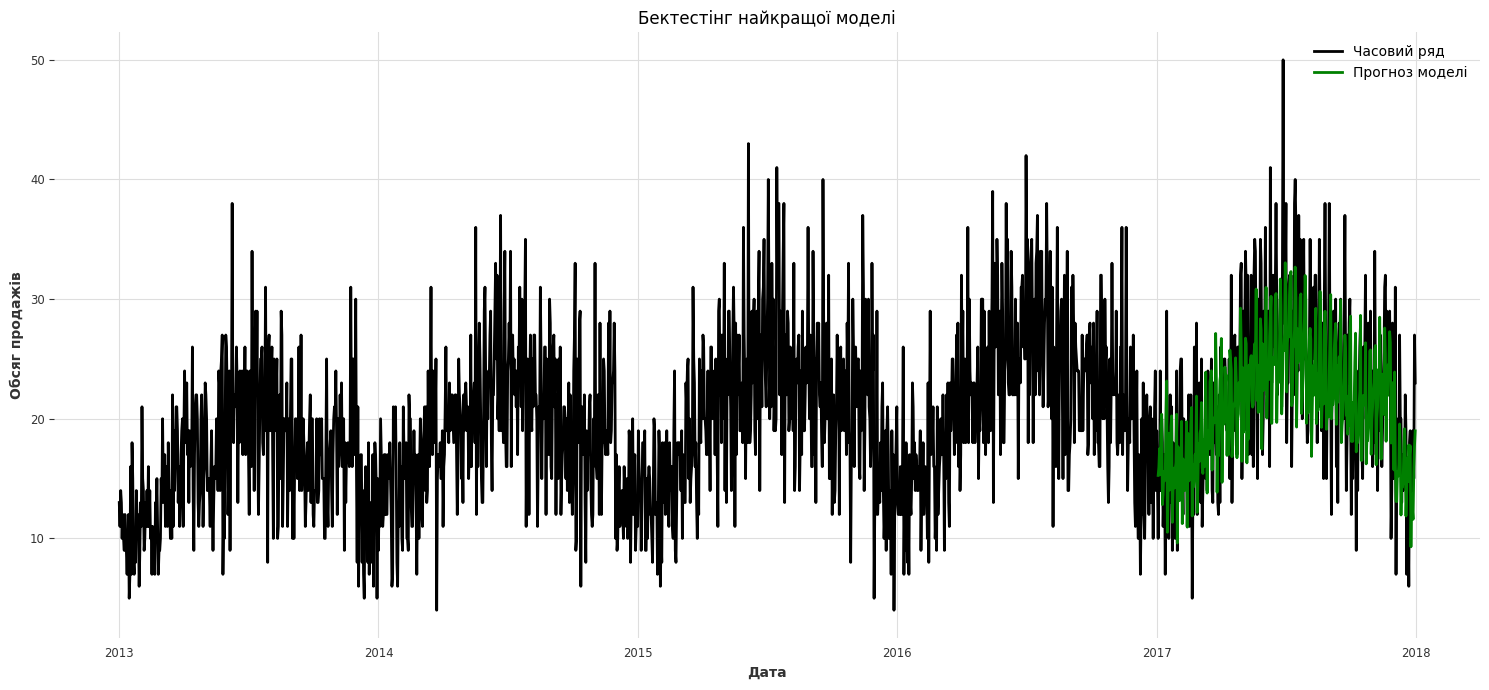

In [49]:
hfc_params = {
    "series": series,
    "start": pd.Timestamp("2017-01-01"),
    "forecast_horizon": 3,
    "verbose": True,
}

historical_fcast = model_with_features_2.historical_forecasts(last_points_only=True, past_covariates=all_covariates, **hfc_params)

plt.figure(figsize=(15, 7))
series.plot(label='Часовий ряд')
historical_fcast.plot(label='Прогноз моделі', color='green')
plt.legend()
plt.title('Бектестінг найкращої моделі')
plt.ylabel('Обсяг продажів')
plt.xlabel('Дата')
plt.tight_layout();


mape_hf = mape(series, historical_fcast)
print(f"MAPE: {mape_hf:.2f}%")

Всю варіантивність не вгадали, але виглядає непогано!

17. На цьому етапі ви зрозуміли, як моделювати продажі одного айтему з 1 магазину. Як би ви підійшли до задачі прогнозування продажів в наступному місяці для кожного з 50 айтемів в кожному з 10 магазинів? Опишіть загальний підхід
- яку модель ви б використали
- скільки моделей ви б тренували
- обгрунтуйте свій вибір.

Для прогнозування продажів кожного товару в кожному магазині бачу 2 можливих варіанти:  
1. Передбачати на 1 натренованій моделі, яка дала найкращі показники  
2. Тренувати окремі моделі для кожної пари "магазин-товар"  
Обидві стратегії мають свої переваги та недоліки.  
Особисто я би спробувала спочатку зробити передбачення для всіх пар на вже навченій моделі, оскільки вибірковий аналіз на початку показав, що різні товари мають схожі тренд та сезонність.  
Тому я би зробила передбачення, відфільтрувала результати, в яких mape>20.84% і потім вже або редагувала б гіперпараметри моделі або тренувала іншу модель.

In [61]:
df = pd.read_csv("/content/drive/MyDrive/ML_Course/Data/time_series/train.csv")
df["date"] = pd.to_datetime(df["date"])
if "date" not in df.columns:
    df = df.reset_index()

# 📌 4. Конвертуємо в `TimeSeries` для всіх `(store, item)`
series = TimeSeries.from_group_dataframe(df, time_col="date", group_cols=["store", "item"], value_cols="sales")

# 📌 5. Розділяємо на тренувальний та тестовий набори
split_date = pd.Timestamp("2017-10-01")
train_series = []
test_series = []

for ts in series:
    train, test = ts.split_before(split_date)
    train_series.append(train)
    test_series.append(test)

extended_time_index = pd.date_range(
    start=series[0].start_time(),  # Беремо стартовий час з першого ряду
    end=series[0].end_time() + pd.Timedelta(days=100),
    freq=series[0].freq_str
)

# Генеруємо атрибути часу
dayofweek_extended = datetime_attribute_timeseries(extended_time_index, attribute="dayofweek", one_hot=True)
month_extended = datetime_attribute_timeseries(extended_time_index, attribute="month", one_hot=True)
day_extended = datetime_attribute_timeseries(extended_time_index, attribute="day", one_hot=True)

# Об'єднуємо в один набір ковариатів
temp_covariates = dayofweek_extended.concatenate(month_extended, axis=1)
all_covariates = temp_covariates.concatenate(day_extended, axis=1)

# 📌 5. Розділяємо `past_covariates` на `train_past_covariates` та `test_past_covariates`
train_past_covariates = []
test_past_covariates = []

for ts in series:
    past_cov = all_covariates.slice_intersect(ts)  # Вибираємо тільки ті дати, які є у відповідному ряді
    train_past, test_past = past_cov.split_before(split_date)  # Розділяємо аналогічно основному ряду
    train_past_covariates.append(train_past)
    test_past_covariates.append(test_past)

model_with_features_3 = XGBModel(
    lags=[-1, -7, -14, -21, -28, -56, -91],
    output_chunk_length=45,
    n_estimators=300,
    max_depth=2,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state = 5,
    lags_past_covariates=[-1, -7, -14, -21, -28, -56, -91],
    verbosity=1,
    use_static_covariates=False
)

model_with_features_3.fit(train_series, past_covariates=train_past_covariates)


XGBModel(lags=[-1, -7, -14, -21, -28, -56, -91], lags_past_covariates=[-1, -7, -14, -21, -28, -56, -91], lags_future_covariates=None, output_chunk_length=45, output_chunk_shift=0, add_encoders=None, likelihood=None, quantiles=None, random_state=5, multi_models=True, use_static_covariates=False, n_estimators=300, max_depth=2, learning_rate=0.1, subsample=0.8, colsample_bytree=0.8, verbosity=1)

In [66]:
# Розширюємо часовий індекс до 2018-02-14 (90 днів після останньої тестової дати)
extended_time_index = pd.date_range(
    start=series[0].start_time(),
    end=series[0].end_time() + pd.Timedelta(days=90),  # Тепер достатньо для прогнозу
    freq=series[0].freq_str
)

# Генеруємо past_covariates для всього розширеного діапазону
dayofweek_extended = datetime_attribute_timeseries(extended_time_index, attribute="dayofweek", one_hot=True)
month_extended = datetime_attribute_timeseries(extended_time_index, attribute="month", one_hot=True)
day_extended = datetime_attribute_timeseries(extended_time_index, attribute="day", one_hot=True)

# Об'єднуємо всі коваріати
temp_covariates = dayofweek_extended.concatenate(month_extended, axis=1)
all_covariates = temp_covariates.concatenate(day_extended, axis=1)


In [68]:
test_past_covariates = []
for ts in test_series:
    # Отримуємо часовий індекс для цього тестового ряду та розширюємо його ще на 90 днів
    future_time_index = pd.date_range(
        start=ts.start_time(),
        periods=len(ts) + 90,  # Додаємо 90 днів
        freq=ts.freq_str
    )

    # Розширюємо past_covariates, щоб вони включали майбутній період
    past_cov = all_covariates.slice_intersect(TimeSeries.from_times_and_values(future_time_index, np.zeros(len(future_time_index))))

    test_past_covariates.append(past_cov)

# Перевіряємо, чи тепер past_covariates містять достатньо дат
print(test_past_covariates[0].time_index[[0, -1]])  # Повинно бути до 2018-02-14




DatetimeIndex(['2017-10-01', '2018-03-31'], dtype='datetime64[ns]', name='time', freq=None)


In [69]:
forecast = model_with_features_3.predict(n=90, series=test_series, past_covariates=test_past_covariates)



In [70]:
mape_results = {}

unique_stores = df["store"].unique()
unique_items = df["item"].unique()
num_items = len(unique_items)

for i, (test, pred) in enumerate(zip(test_series, forecast)):
    store = unique_stores[i // num_items]
    item = unique_items[i % num_items]

    mape_value = mape(test, pred)

    mape_results[(store, item)] = mape_value

print(mape_results)


/usr/local/lib/python3.11/dist-packages/darts/metrics/metrics.py:2222: RuntimeWarning: Mean of empty slice
  return np.nanmean(
/usr/local/lib/python3.11/dist-packages/darts/metrics/metrics.py:372: RuntimeWarning: Mean of empty slice
  vals = component_reduction(vals, axis=COMP_AX)


{(1, 1): nan, (1, 2): nan, (1, 3): nan, (1, 4): nan, (1, 5): nan, (1, 6): nan, (1, 7): nan, (1, 8): nan, (1, 9): nan, (1, 10): nan, (1, 11): nan, (1, 12): nan, (1, 13): nan, (1, 14): nan, (1, 15): nan, (1, 16): nan, (1, 17): nan, (1, 18): nan, (1, 19): nan, (1, 20): nan, (1, 21): nan, (1, 22): nan, (1, 23): nan, (1, 24): nan, (1, 25): nan, (1, 26): nan, (1, 27): nan, (1, 28): nan, (1, 29): nan, (1, 30): nan, (1, 31): nan, (1, 32): nan, (1, 33): nan, (1, 34): nan, (1, 35): nan, (1, 36): nan, (1, 37): nan, (1, 38): nan, (1, 39): nan, (1, 40): nan, (1, 41): nan, (1, 42): nan, (1, 43): nan, (1, 44): nan, (1, 45): nan, (1, 46): nan, (1, 47): nan, (1, 48): nan, (1, 49): nan, (1, 50): nan, (2, 1): nan, (2, 2): nan, (2, 3): nan, (2, 4): nan, (2, 5): nan, (2, 6): nan, (2, 7): nan, (2, 8): nan, (2, 9): nan, (2, 10): nan, (2, 11): nan, (2, 12): nan, (2, 13): nan, (2, 14): nan, (2, 15): nan, (2, 16): nan, (2, 17): nan, (2, 18): nan, (2, 19): nan, (2, 20): nan, (2, 21): nan, (2, 22): nan, (2, 23): 